In [1]:
from utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time
from typing import Optional
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.models import (
                          BlockRNNModel, 
                          TCNModel, 
                          RNNModel, 
                          TransformerModel, 
                          NLinearModel,
                          DLinearModel,
                          NBEATSModel,
                          XGBModel,
                          LinearRegressionModel,
                          TFTModel,
                         )
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import CRPS.CRPS as forecastscore
from datetime import datetime, timedelta


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

In [2]:
np.sort(targets.datetime.unique())

array(['2016-03-04', '2016-03-05', '2016-03-06', ..., '2023-07-17',
       '2023-07-18', '2023-07-19'], dtype=object)

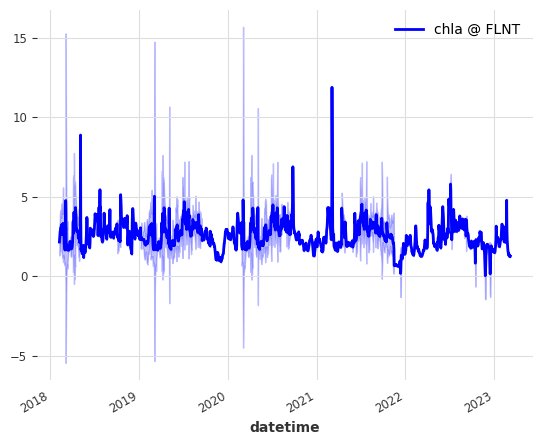

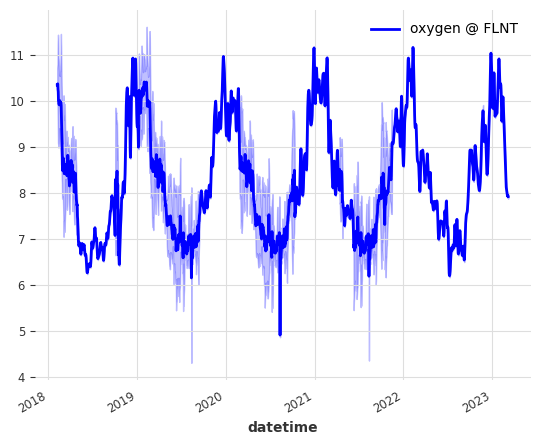

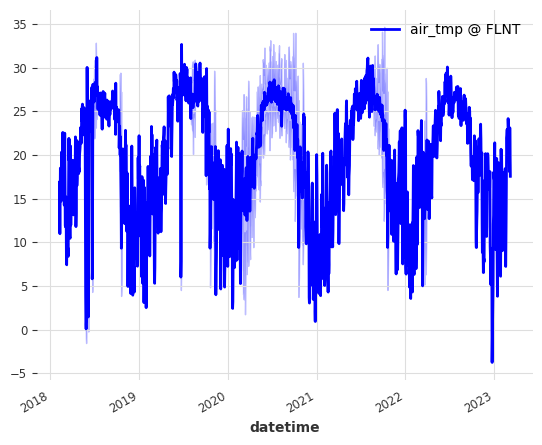

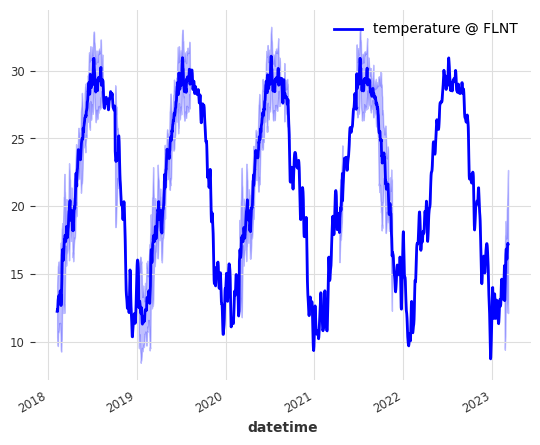

In [3]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load("FLNT")
data_preprocessor.plot_by_site("FLNT")

Need to preprocess a training set and validation set

In [2]:
np.sort(targets.datetime.unique())

array(['2016-03-04', '2016-03-05', '2016-03-06', ..., '2023-07-17',
       '2023-07-18', '2023-07-19'], dtype=object)

In [5]:
from utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time
from typing import Optional
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.models import (
                          BlockRNNModel, 
                          TCNModel, 
                          RNNModel, 
                          TransformerModel, 
                          NLinearModel,
                          DLinearModel,
                          NBEATSModel,
                          XGBModel,
                          LinearRegressionModel,
                          TFTModel,
                         )
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import CRPS.CRPS as forecastscore
from datetime import datetime, timedelta


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

train_preprocessor = TimeSeriesPreprocessor(
    load_dir_name="preprocessed_validate/",
    validation_split_date="2023-07-19",   
)
train_preprocessor.preprocess_data("FLNT")
train_preprocessor.save()

In [9]:
import pandas as pd

# Your initial timestamp
initial_timestamp = pd.Timestamp('2023-11-09')

# Define the interval (e.g., 1 day)
interval = pd.Timedelta(days=30)

# Number of dates you want to generate
num_dates = 11

# Generate dates at the specified interval
date_range = pd.date_range(initial_timestamp + interval, periods=num_dates, freq=interval)

# Print the result
print(date_range)

DatetimeIndex(['2023-12-09', '2024-01-08', '2024-02-07', '2024-03-08',
               '2024-04-07', '2024-05-07', '2024-06-06', '2024-07-06',
               '2024-08-05', '2024-09-04', '2024-10-04'],
              dtype='datetime64[ns]', freq='30D')


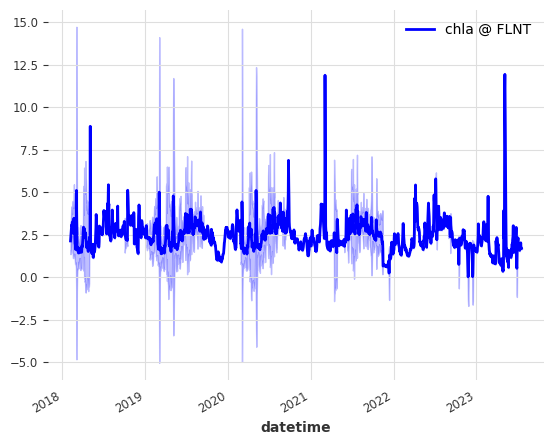

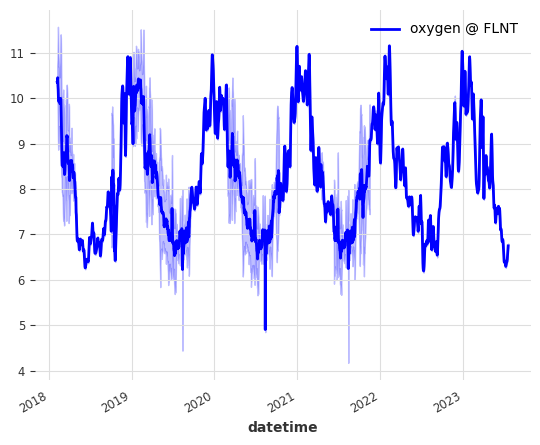

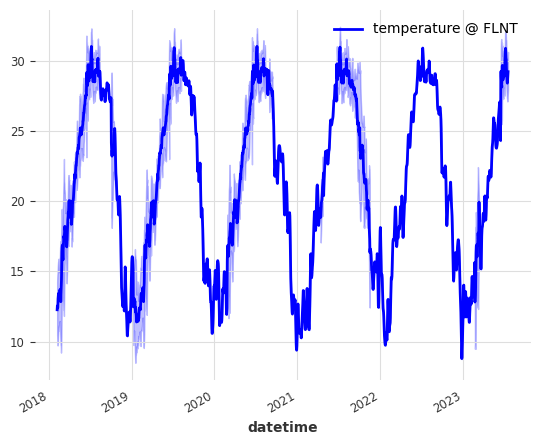

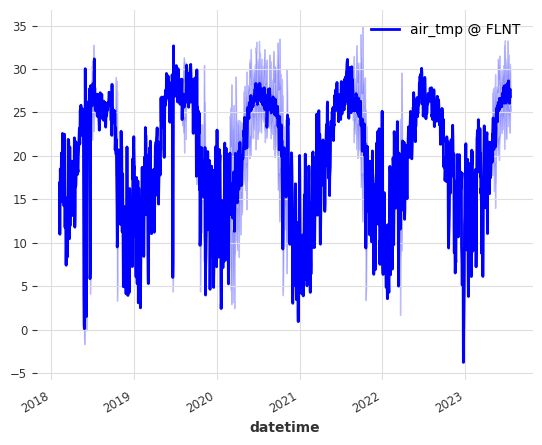

In [6]:
train_preprocessor.plot_by_site("FLNT")

In [1]:
from datetime import datetime, timedelta

def doy_range(year, month):
    # Get the first day of the month
    first_day = datetime(year, month, 1)

    # Calculate the last day of the month
    if month == 12:
        last_day = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)

    # Calculate the day of year for the first and last day
    doy_first_day = first_day.timetuple().tm_yday
    doy_last_day = last_day.timetuple().tm_yday

    return doy_first_day, doy_last_day

# Example usage
year = 2023
month = 11
doy_start, doy_end = doy_range(year, month)

print(f"DOY range for {year}-{month:02d}: {doy_start} to {doy_end}")


DOY range for 2023-11: 305 to 334


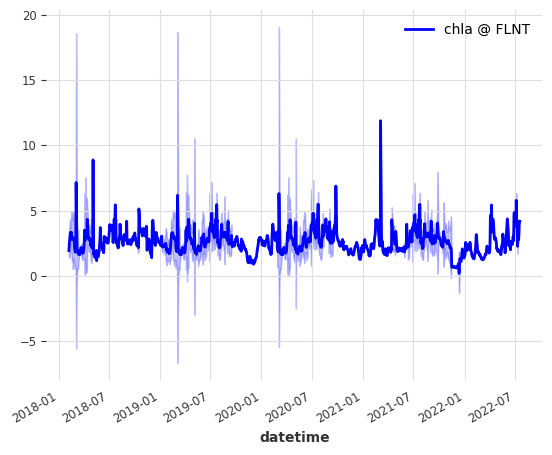

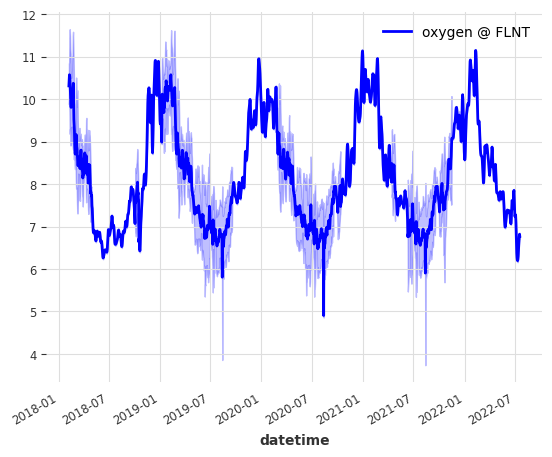

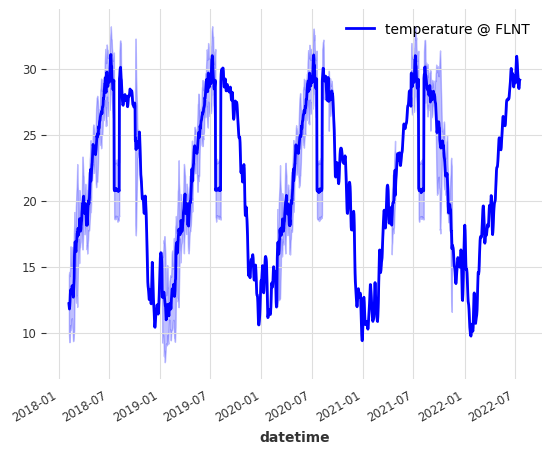

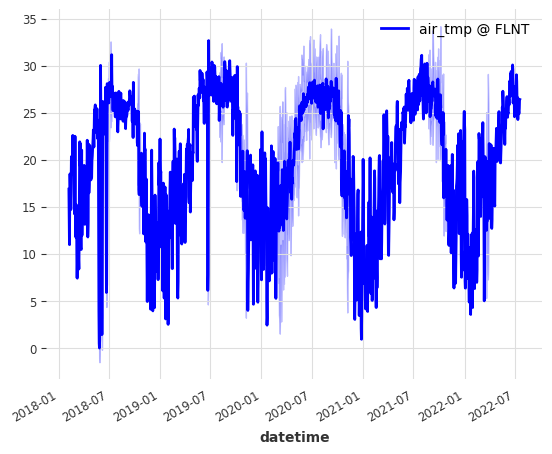

In [6]:
train_preprocessor.plot_by_site("FLNT")

In [ ]:
train_preprocessor = TimeSeriesPreprocessor(
    load_dir_name="preprocessed_train",
    validation_split_date="2023-07-19",   
)
train_preprocessor.preprocess_data("FLNT")
train_preprocessor.save()

In [ ]:
class BaseForecaster():
    def __init__(self,
                 model: Optional[str] = None,
                 data_preprocessor: Optional = None,
                 target_variable: Optional[str] = None,
                 datetime_column_name: Optional[str] = "datetime",
                 covariates_names: Optional[list] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = "2023-03-09", #YYYY-MM-DD n.b. this is inclusive
                 model_hyperparameters: Optional[dict] = None,
                 model_likelihood: Optional[dict] = None,
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 epochs: Optional[int] = 1,
                 num_samples: Optional[int] = 500,
                 num_trials: Optional[int] = 50,
                 seed: Optional[int] = 0,
                 verbose: Optional[bool] = False,
                 targets_csv: Optional[str] = "targets.csv.gz",
                 ):
        self.model_ = {"BlockRNN": BlockRNNModel, 
                       "TCN": TCNModel, 
                       "RNN": RNNModel, 
                       "Transformer": TransformerModel,
                       "NLinear": NLinearModel,
                       "DLinear": DLinearModel,
                       "XGB": XGBModel,
                       "NBEATS": NBEATSModel,
                       "Linear": LinearRegressionModel,
                       "TFT": TFTModel}[model]
        self.data_preprocessor = data_preprocessor
        self.target_variable = target_variable
        self.datetime_column_name = datetime_column_name
        self.covariates_names = covariates_names
        self.covariates = None
        self.output_csv_name = output_csv_name
        self.split_date = pd.to_datetime(validation_split_date)
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        self.epochs = epochs
        self.num_samples = num_samples
        self.num_trials = num_trials
        self.seed = seed
        self.tuned = False
        self.verbose = verbose
        self.dropout = None
        self.targets_df = pd.read_csv(targets_csv)
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length" : 180}
        else:
            self.hyperparams = model_hyperparameters
        self.model_likelihood = model_likelihood
        # Try to get validation set from targets and not preprocessor

        self._preprocess_data()
        
    def _preprocess_data(self):
        """
        Performs gap filling and processing of data into format that
        Darts models will accept
        """
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]

        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable in \
                self.data_preprocessor.site_missing_variables:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable]

        if self.covariates_names is not None:
            # And not using the covariates that did not yield GP fits beforehand
            for null_variable in self.data_preprocessor.site_missing_variables:
                self.covariates_names.remove(null_variable)
    
            # Initializing covariates list then concatenating in for loop
            self.covariates = stitched_series_dict[self.covariates_names[0]]
            for cov_var in self.covariates_names[1:]:
                self.covariates = self.covariates.concatenate(stitched_series_dict[cov_var], 
                                                              axis=1, 
                                                              ignore_time_axis=True)
            self.covariates = self.covariates.median()
            
        # Taking the median now to accomodate using doy covariates
        self.training_set = self.inputs.median()

    def tune(self,
             hyperparameter_dict: Optional[dict]
            ):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        Input dictionary will be of the form {"hyperparamter": [values to be tested]}
        """
        self.validation_set = self.get_validation_set()
        if len(self.validation_set) != self.forecast_horizon:
            raise Exception(f"There is missing data in the specified forecast window at {self.site_id}. " + \
                            "This site will not be used for evaluating hyperparameters.")
        # Setting up an optuna Trial
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
            hyperparams = {key: trial.suggest_categorical(key, value) 
                                               for key, value in hyperparameter_dict.items()}

            # Need to handle lags and time axis encoders
            hyperparams = self.prepare_hyperparams(hyperparams)

            model = self.model_(**hyperparams,
                                output_chunk_length=self.forecast_horizon,
                                **self.model_likelihood,
                                random_state=self.seed)

            extras = {"verbose": False,
                      "epochs": self.epochs}
            predict_kws = {"n": self.forecast_horizon,
                           "num_samples": self.num_samples}
            self.scaler = Scaler()
            # Need to treat transformation differently if models use covariates or not
            if self.covariates is not None:
                training_set, covariates = self.scaler.fit_transform([self.training_set.median(),
                                                                      self.covariates.median()])
                extras["past_covariates"] = covariates
                predict_kws["past_covariates"] = covariates
            else:
                training_set = self.scaler.fit_transform(self.training_set.median())

            # Need to delete epochs which aren't used in the regression models
            if self.model_ == XGBModel or self.model_ == LinearRegressionModel:
                del extras["epochs"]
                del extras["verbose"]

            assert training_set.time_index[-1] == self.split_date, "There is a" +\
             " misalignment between the training set and the specified validation" +\
             " split date. Note that the validation split date is defined to" +\
             " include the last date of the training set."
            
            model.fit(training_set, **extras)
            
            predictions = model.predict(**predict_kws)
            predictions = self.scaler.inverse_transform(predictions)

            crps_ = crps(predictions, 
                         self.validation_set,
                        )
            
            crps_mean = crps_.mean(axis=0).values()[0][0]
            return crps_mean if crps_mean != np.nan else float("inf")

        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=self.num_trials)
        
        self.hyperparams = study.best_trial.params
        self.tuned = True

    def get_validation_set(self):
        # take validation_split_date and add number of dates
        date_range = pd.date_range(self.split_date + pd.DateOffset(days=1), 
                                   periods=self.forecast_horizon, 
                                   freq='D')
        # Filter targets df for site and variable
        site_df = self.targets_df[self.targets_df["site_id"] == self.site_id]
        site_var_df_ = site_df[["datetime", self.target_variable]]
        site_var_df = site_var_df_.copy()
        site_var_df["datetime"] = pd.to_datetime(site_var_df_["datetime"])
        validation_df = pd.DataFrame()
        # Now creating a new dataframe of observed series from the forecast
        # window
        for date in date_range:
            entry = site_var_df[site_var_df.datetime == date]
            validation_df = pd.concat([validation_df, entry], 
                                      axis=0).reset_index(drop=True)
        
        return validation_df[self.target_variable]
        
    def make_forecasts(self):
        """
        This function fits a Darts model to the training_set
        """
        print(self.hyperparams, self.model_likelihood)
        
        # Need to handle lags and time axis encoders
        self.hyperparams = self.prepare_hyperparams(self.hyperparams)

        self.model = self.model_(**self.hyperparams,
                                 output_chunk_length=self.forecast_horizon,
                                 **self.model_likelihood,
                                 random_state=self.seed)
        self.scaler = Scaler()
        extras = {"verbose": self.verbose,
                  "epochs": self.epochs}
        predict_kws = {"n": self.forecast_horizon,
                       "num_samples": self.num_samples}

        # Need to account for models that don't use past covariates
        if self.covariates is not None:
            # Changing to median so that I can use the time axis encoder.
            # Darts does not allow inputs of mixed dimension.
            training_set, covariates = self.scaler.fit_transform([self.training_set.median(),
                                                                  self.covariates.median()])
            extras["past_covariates"] = covariates
            predict_kws["past_covariates"] = covariates
        else:
            training_set = self.scaler.fit_transform(self.training_set.median())

        # Regression models don't accept these key word arguments for .fit()
        if self.model_ == XGBModel or self.model_ == LinearRegressionModel:
            del extras["epochs"]
            del extras["verbose"]

        assert training_set.time_index[-1] == self.split_date, "There is a" +\
         " misalignment between the training set and the specified validation split" +\
         " date. Note that the validation split date is defined to include the last" +\
         " date of the training set."
        
        self.model.fit(training_set,
                       **extras)

        # Accounting for if there is dropout
        if "dropout" in list(self.model_likelihood.keys()):
            predict_kws["mc_dropout"] = True
            
        predictions = self.model.predict(**predict_kws)
        predictions = self.scaler.inverse_transform(predictions)

        predictions.pd_dataframe().to_csv(self.output_csv_name)

    def get_historicals_and_residuals(self):
        """
        This function creates a historical forecast along with their residual errors 
        """
        # This presumes that the scaler will not have been modified in interim 
        # from calling `make_forecasts`
        historical_forecast_kws = {"num_samples": self.num_samples,
                                   "forecast_horizon": self.forecast_horizon,
                                   "retrain": False,
                                   "last_points_only": False,
                                  }
        if self.covariates is not None:
            training_set, covariates = self.scaler.transform([self.training_set,
                                                              self.covariates])
            historical_forecast_kws["past_covariates"] = covariates
        else:
            training_set = self.scaler.transform([self.training_set])
        historical_forecast_kws["series": training_set]
        
        covariates, _ = covariates.split_after(training_set.time_index[-1])
        historical_forecasts = self.model.historical_forecasts(
                                                    **historical_forecast_kws
                                                              )
        historical_forecasts = [self.scaler.inverse_transform(historical_forecast) for
                                                historical_forecast in historical_forecasts]
        # Getting the target time series slice for the historical forecast
        self.historical_ground_truth = self.training_set.slice(
                                            historical_forecasts[0].time_index[0], 
                                            historical_forecasts[-1].time_index[-1])

        # Now concatenating the historical forecasts which were returned
        # as a list above
        self.historical_forecasts = historical_forecasts[0]
        for time_series in historical_forecasts[1:]:
            self.historical_forecasts = self.historical_forecasts.concatenate(time_series, 
                                                                axis=0, 
                                                                ignore_time_axis=True)


        # Defining residual as difference between the median and ground truth
        self.residuals = self.historical_ground_truth - self.historical_forecasts.median()

    def prepare_hyperparams(self, hyperparams_dict):
        if "add_encoders" in hyperparams_dict.keys():
            if hyperparams_dict["add_encoders"] == "past":
                hyperparams_dict["add_encoders"] = {'datetime_attribute': {'past': ['dayofyear']}}
            elif hyperparams_dict["add_encoders"] == "future":
                hyperparams_dict["add_encoders"] = {'datetime_attribute': {'future': ['dayofyear']}}
            elif hyperparams_dict["add_encoders"] == "past_and_future":
                hyperparams_dict["add_encoders"] = {'datetime_attribute': {'past': ['dayofyear'], 
                                                                   'future': ['dayofyear']}}
            elif hyperparams_dict["add_encoders"] == "none":
                del hyperparams_dict["add_encoders"]
                
        if "lr" in hyperparams_dict.keys():
            hyperparams_dict["optimizer_kwargs"] = {"lr": hyperparams_dict["lr"]}
            del hyperparams_dict["lr"]

        return hyperparams_dict